In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.datasets import fetch_20newsgroups
import gensim

### Import cleaned datasets

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/MIS6-Sem6/outputs/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MIS6-Sem6/outputs/df_test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46307 entries, 0 to 46306
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     46307 non-null  object 
 1   condition    46307 non-null  object 
 2   rating       46307 non-null  float64
 3   usefulCount  46307 non-null  int64  
 4   review       46305 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


In [6]:
df_train.dropna(inplace=True)

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46132 entries, 0 to 46131
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     46132 non-null  object 
 1   condition    46132 non-null  object 
 2   rating       46132 non-null  float64
 3   usefulCount  46132 non-null  int64  
 4   review       46130 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


In [8]:
df_test.dropna(inplace=True)

In [9]:
from wordcloud import WordCloud

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10,8), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
        
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [10]:
top_words=df_train.review.value_counts(normalize=True)[:40].keys()

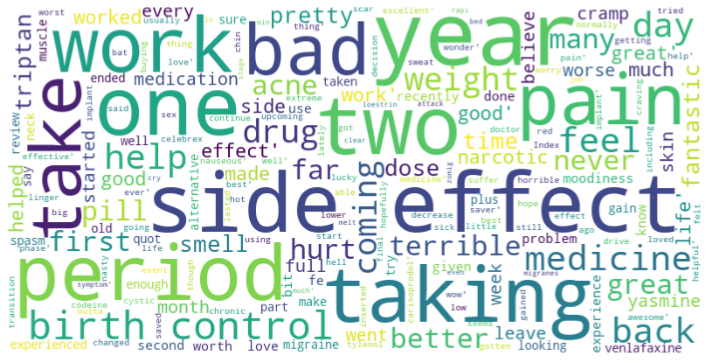

In [11]:
plot_wordcloud(top_words)
plt.savefig('wordcloud.svg')

In [12]:
df_train.rating.value_counts(normalize=True)

10.0    0.299557
9.0     0.172616
1.0     0.138300
8.0     0.115819
7.0     0.059151
5.0     0.052003
2.0     0.046021
3.0     0.043149
6.0     0.040838
4.0     0.032545
Name: rating, dtype: float64

In [13]:
# Remove 4-7 star reviews
df_train2 = df_train.drop(df_train[(df_train['rating'] > 4.0) & (df_train['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_train2['sentiment'] = np.where(df_train2['rating'] >= 7, '1', '0')

df_train2

,drugName,condition,rating,usefulCount,review,sentiment
0,Mirtazapine,Depression,10.0,22,tried antidepressant year citalopram fluoxetin...,1
1,Mesalamine,"Crohn's Disease, Maintenance",8.0,17,son crohn disease done well asacol no complain...,1
2,Bactrim,Urinary Tract Infection,9.0,3,quick reduction symptom,1
3,Contrave,Weight Loss,9.0,35,contrave combine drug used alcohol smoking opi...,1
4,Cyclafem 1 / 35,Birth Control,9.0,4,birth control one cycle reading review type si...,1
...,...,...,...,...,...,...
46302,Apri,Birth Control,9.0,18,started taking apri month ago breats got notic...,1
46303,Escitalopram,Anxiety,9.0,11,taking lexapro escitaploprgram since first lik...,1
46304,Levonorgestrel,Birth Control,8.0,7,married year old no kid taking pill hassle dec...,1
46305,Tapentadol,Pain,1.0,20,prescribed nucynta severe neck shoulder pain t...,0


In [14]:
# Remove 4-7 star reviews
df_test2 = df_test.drop(df_test[(df_test['rating'] > 4.0) & (df_test['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_test2['sentiment'] = np.where(df_test2['rating'] >= 7, '1', '0')

In [15]:
# Note that the dataset has mostly positive reviews
df_train2.sentiment.value_counts(normalize=True)

1    0.682643
0    0.317357
Name: sentiment, dtype: float64

In [16]:
export_csv = df_train2.to_csv(r'df_train_sentiment.csv', index = None, header=True)
export_csv = df_test2.to_csv(r'df_test_sentiment.csv', index = None, header=True)

In [17]:
X_train=df_train2.review
y_train=df_train2.sentiment
X_test=df_test2.review
y_test=df_test2.sentiment

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't",
     "mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound',]
for j in a:
    stop.add(j)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ab,abdomen,abdominal,abilify,ability,ablation,able,abnormal,abnormality,abnormally,...,zombified,zomig,zone,zoned,zonegran,zovia,zumba,zyban,zyprexa,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [ ]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [ ]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [ ]:
cm1=conf_matrix(y_test, y_pred_cv1)
plt.savefig('cm1_lr1.svg')

In [ ]:
cm2=conf_matrix(y_test, y_pred_cv2)
plt.savefig('cm2_lr2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

### Naive Bayes

In [ ]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [ ]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

In [ ]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)
plt.savefig('cm3_nb1.svg')

In [ ]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)
# plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm4_nb2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

### Try using TF-IDF instead of Count Vectorizer

In [ ]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

In [ ]:
tfidf2 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [ ]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)
plt.savefig('cm5_tf_idf_lr1.svg')

In [ ]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)
plt.savefig('cm6_tf_idf_lr2.svg')

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm8 = conf_matrix(y_test, y_pred_tfidf1_nb)
plt.savefig('cm8_tf_idf_nb1.svg')

In [ ]:
# # Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm9 = conf_matrix(y_test, y_pred_tfidf2_nb)
plt.savefig('cm9_tf_idf_nb2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm8, cm9)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results